In [12]:
# # # Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
libxrender1 is already the newest version (1:0.9.10-1build4).
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.3).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Using cached faiss_cpu-1.8.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.7 kB)
Using cached faiss_cpu-1.8.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (27.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.20.0 requires faiss-cpu<=1.8.0, but you have faiss-cpu 1.8.0.post1 which is incompatible.


# Imports and Constants

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
from iris.io.dataclasses import IrisTemplate
from joblib import Parallel, delayed
import hnsw
from iris_integration import (
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
)

In [36]:
n_jobs = 4 # Fit to CPU
DIM = (2, 32, 200)
X, Y = DIM [1:]

In [152]:
precision = 0.99
db_range = np.arange(1000, 10001, 1000)
Ms = np.arange(10, 101, 10)
efConstructions = np.arange(50, 501, 50)
efSearchs = np.arange(50, 501, 50)

In [38]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 100)

# Following the multinotebook threading

In [141]:
threading_df = pd.read_parquet('threading_df.parquet')
ratio = (threading_df['status'] != 'Not Started').mean()
print(f'MultiNotebook Threading is at {ratio:.1%} progress')
threading_df[threading_df['status'] == 'Pending']

MultiNotebook Threading is at 100.0% progress


,M,efConstruction,efSearch,status


In [134]:
# notebook_threading_count = 6
# stats_df_lst = [pd.read_parquet(f"stats_df{i}.parquet") for i in range(1, notebook_threading_count+1)]
# final_stats_df = pd.concat(stats_df_lst).reset_index(drop=True)
# final_stats_df.to_parquet("stats_df.parquet")

# Analysis

In [135]:
stats_df = pd.read_parquet('stats_df.parquet')

In [40]:
def get_results_specific_K(stats_df, K):
    return stats_df.apply(lambda row: sum(row['results'] <= K) / row['num_experiments'], axis=1)

In [41]:
def get_minimal_K_by_precision(data, precision):
    combined_array = np.concatenate(data['results'].values) if isinstance(data, pd.DataFrame) else data
    return np.sort(combined_array)[int(precision * len(combined_array))] + 1

In [42]:
def get_minimal_k_distribution(data, precision):
    return np.sort(np.array(data['results'].apply(lambda x: get_minimal_K_by_precision(x, precision))))

In [153]:
stats_df[f'minimal_k_{int(precision*100)}_precision'] = stats_df['results'].apply(lambda x: get_minimal_K_by_precision(x, precision))

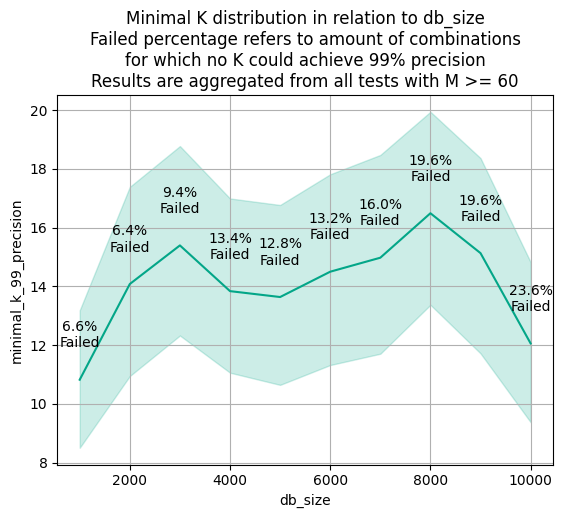

In [169]:
plot_feature = 'db_size'
mask = (stats_df['M'] >= 60)
failed_exp = stats_df[mask].groupby(plot_feature)[f'minimal_k_{int(precision*100)}_precision'].apply(lambda x: np.isinf(x)).groupby(plot_feature).mean()
lineplot_data = stats_df[mask & (~np.isinf(stats_df['minimal_k_99_precision']))].groupby(plot_feature)['minimal_k_99_precision'].mean()
sns.lineplot(stats_df[mask & (~np.isinf(stats_df['minimal_k_99_precision']))], x=plot_feature, y='minimal_k_99_precision', color='#03A688')
for feature_value, perc in failed_exp.items():
    y_value = lineplot_data.loc[feature_value]
    plt.text(feature_value, y_value+1, f'{perc:.1%}\nFailed', ha='center', va='bottom')
plt.title(f'Minimal K distribution in relation to {plot_feature}\nFailed percentage refers to amount of combinations\nfor which no K could achieve {precision:.0%} precision\nResults are aggregated from all tests with M >= 60')
plt.grid()
plt.show()

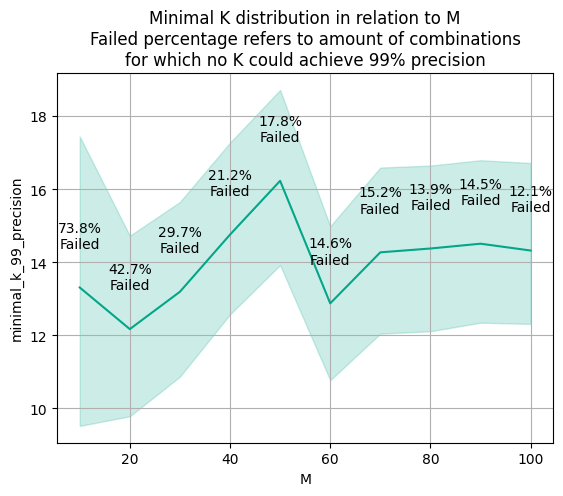

In [164]:
plot_feature = 'M'
mask = np.ones(len(stats_df), dtype='bool')
failed_exp = stats_df[mask].groupby(plot_feature)[f'minimal_k_{int(precision*100)}_precision'].apply(lambda x: np.isinf(x)).groupby(plot_feature).mean()
lineplot_data = stats_df[mask & (~np.isinf(stats_df['minimal_k_99_precision']))].groupby(plot_feature)['minimal_k_99_precision'].mean()
sns.lineplot(stats_df[mask & (~np.isinf(stats_df['minimal_k_99_precision']))], x=plot_feature, y='minimal_k_99_precision', color='#03A688')
for feature_value, perc in failed_exp.items():
    y_value = lineplot_data.loc[feature_value]
    plt.text(feature_value, y_value+1, f'{perc:.1%}\nFailed', ha='center', va='bottom')
plt.title(f'Minimal K distribution in relation to {plot_feature}\nFailed percentage refers to amount of combinations\nfor which no K could achieve {precision:.0%} precision')
plt.grid()
plt.show()

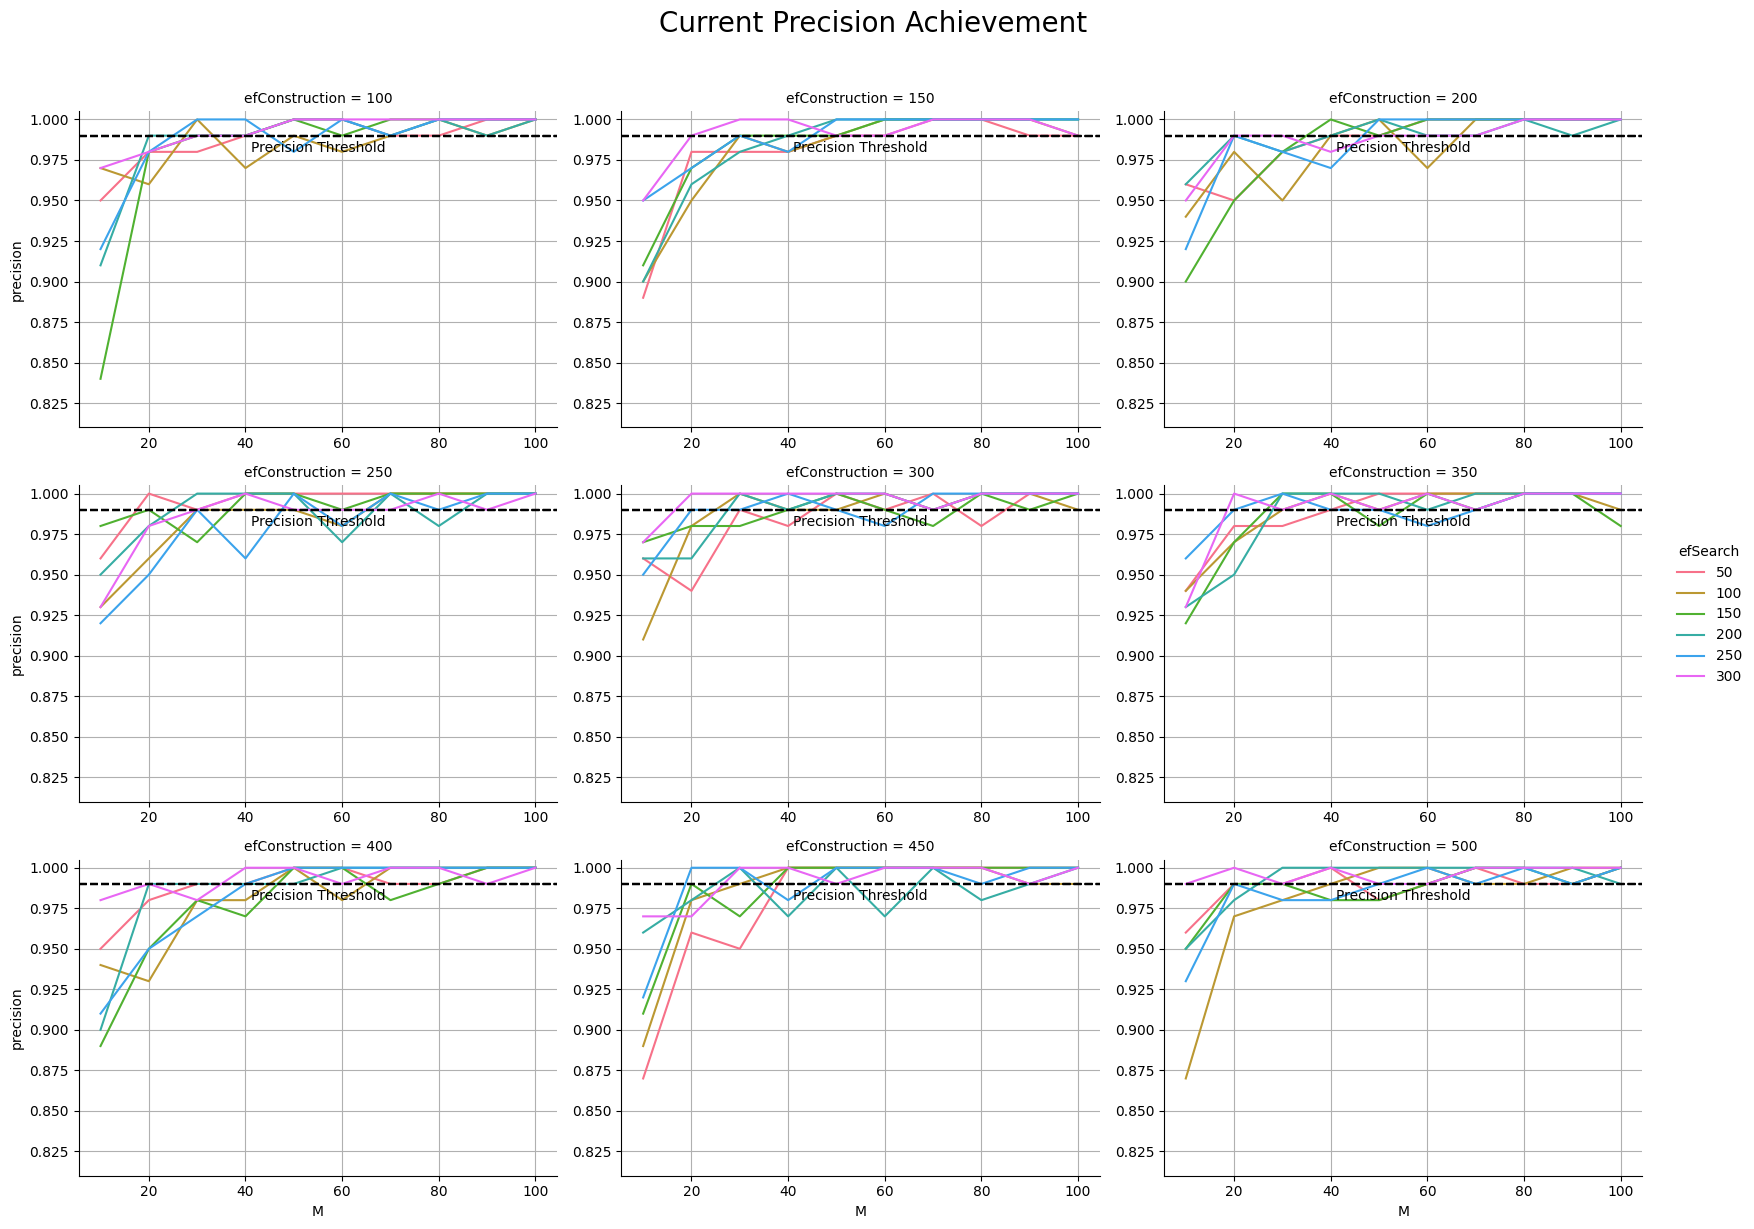

In [167]:
stats_df['precision'] = get_results_specific_K(stats_df, 50)
mask = (
    (stats_df['db_size'] == 10000) &
    (stats_df['efConstruction'] > 50) &
    (stats_df['efSearch'].isin(np.arange(50, 301, 50)))
)
facetgrid = sns.FacetGrid(stats_df[mask].reset_index(drop=True), col='efConstruction', col_wrap=3, hue='efSearch', palette='husl', sharex=False, sharey=False, height=4, aspect=1.4)
facetgrid.map_dataframe(sns.lineplot, x='M', y='precision')
[
    (
        ax.grid(), 
        ax.text(np.mean(Ms), precision-0.01, "Precision Threshold", ha='center'), 
        ax.set_ylim(stats_df.loc[mask, 'precision'].min() - 0.03, 1.005)
    ) for ax in facetgrid.axes.flatten()
]
facetgrid.add_legend()
facetgrid.fig.suptitle("Current Precision Achievements", fontsize=20, y=1.02)
facetgrid.refline(y=precision, linestyle='--', color='k')
plt.show()

In [170]:
# ax = plt.figure().add_subplot(111, projection='3d')
# ax.scatter(stats_df['M'], stats_df['db_size'], stats_df['precision'])
# ax.view_init(elev=30, azim=140)
# ax.set_xlabel('M')
# ax.set_ylabel('db size')
# ax.set_zlabel('precision')
# ax.set_title('M, db_size, and precision\n(across various efConstruction/efSearch values)');

# Modeling

In [104]:
# Possibly cut data only to subsample that reaches accuracy requirments
# stats_df['sufficient'] = stats_df['precision'] > precision_thres 

In [124]:
def func(X, a, b, c): # Adjust according to results on actual data
    x, y = X
    return a + b * x + c * y**2

In [125]:
# Inputs 
x_var = 'M'
y_var = 'db_size'

In [126]:
other_variables = sufficient_df.columns.drop([x_var, y_var]).to_list()
curve_fit_input = stats_df.groupby([x_var, y_var])['precision'].mean().reset_index()

In [127]:
x, y = curve_fit_input[x_var].values, curve_fit_input[y_var].values
target = curve_fit_input['precision'].values

In [128]:
params, covariance = curve_fit(func, (x, y), target)
precision_approx = func((x, y), *params)

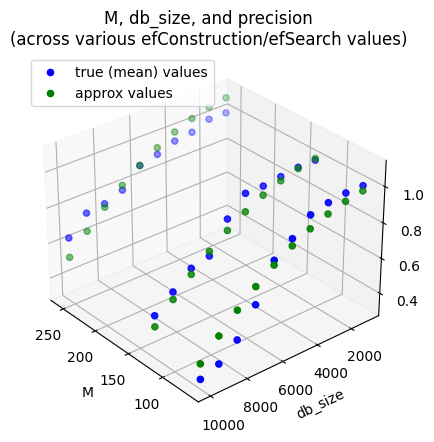

In [130]:
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(x, y, target, color='blue', label='true (mean) values')
ax.scatter(x, y, precision_approx, color='green', label='approx values')
ax.view_init(elev=30, azim=140)
ax.set_xlabel(x_var)
ax.set_ylabel(y_var)
ax.set_zlabel('precision')
ax.set_title(f'{x_var}, {y_var}, and precision\n(across various efConstruction/efSearch values)');
ax.legend();

# Locality Test

## Functions

In [442]:
def numpy_array_to_iris_df(numpy_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    mask = [np.ones(DIM[1:], dtype=np.bool_) for _ in range(DIM[0])]
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(matrix), mask) for matrix in numpy_array)
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

def import_voter_model_rust_implementation(path_low, path_high, total_num_samples, num_samples=None):
    num_samples = num_samples if num_samples else total_num_samples
    assert num_samples <= total_num_samples
    low_high_data_lst = [
        np.unpackbits(np.fromfile(path, dtype=np.uint8), bitorder="little")
        .reshape(total_num_samples, X, Y)
        [np.random.choice(total_num_samples, size=num_samples, replace=False)] for path in [path_low, path_high]
    ]
    data = np.stack(low_high_data_lst, axis=1).astype(bool)
    return numpy_array_to_iris_df(data)

def update_db(db, iris_df, db_size):
    db_current_size = db.get_stats()['db_size']
    assert (db_size - db_current_size) > 0
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for iris in new_irises:
        db.insert(make_query(iris))
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

def process_layer(distances_list, neighborhood_dist, neighborhood_size):
    distances = np.array(distances_list)[:, 0]
    mean_distance = np.mean(distances[:neighborhood_size])
    count_within_dist = np.searchsorted(distances, neighborhood_dist, side='left')
    return mean_distance, count_within_dist

def calculate_neighborhood_distribution(layer_dict, neighborhood_dist, neighborhood_size):
    results = Parallel(n_jobs=n_jobs)(delayed(process_layer)(distances_list, neighborhood_dist, neighborhood_size)
                                  for _, distances_list in layer_dict.items())
    if len(results) == 0:
        return
    mean_distances, neighbor_counts = zip(*results)
    return pd.DataFrame({
        "mean_distances": list(mean_distances),
        "neighbor_counts": list(neighbor_counts)
    })

## Initiate

In [445]:
db_sizes = np.arange(500, 30001, 50)
M = 64
efConstruction = 256
neighborhood_dist = 0.47

In [446]:
iris_df = import_voter_model_rust_implementation(
    path_low='2M_voter_arrays_80k_b45.dat', 
    path_high='2M_voter_arrays_7k_b13.dat', 
    total_num_samples=1000000, 
    num_samples=db_sizes.max()
)
db = hnsw.HNSW(
    M=M, 
    efConstruction=efConstruction, 
    m_L=1/np.log(M), 
    distance_func=distance, 
    query_to_vector_func=query_to_vector
)

In [ ]:
results = pd.DataFrame()
for db_size in db_sizes:
    update_db(db, iris_df, db_size)
    new_results = pd.concat(
            [calculate_neighborhood_distribution(layer, neighborhood_dist, M) for layer in db.layers], 
            keys=range(len(db.layers)), 
            names=['layer','drop']
    ).reset_index().drop(columns='drop').assign(db_size = db_size)
    results = pd.concat([results, new_results], ignore_index=True)
    results.to_parquet("db_analysis_results.parquet")

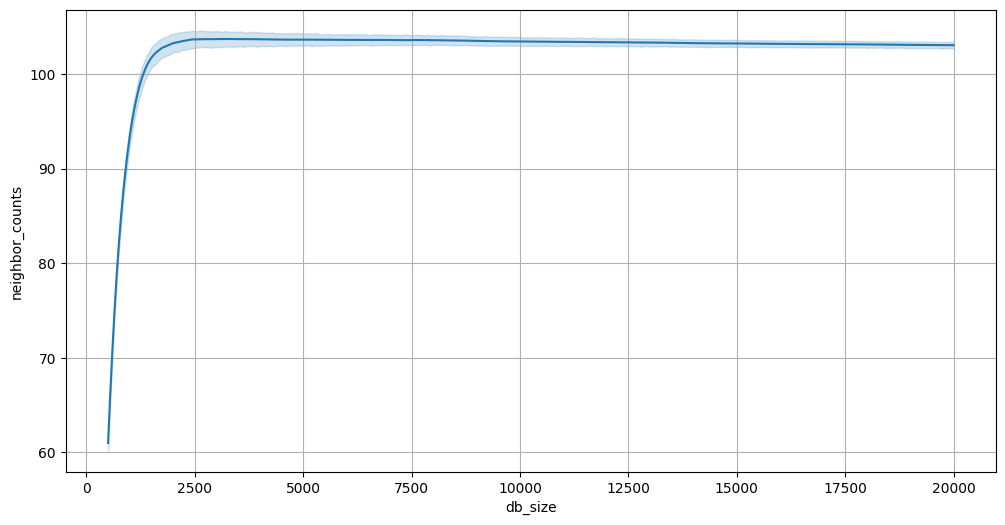

In [460]:
plt.figure(figsize=(12,6))
sns.lineplot(results[results['layer'] == 0], x='db_size', y='neighbor_counts')
plt.grid()

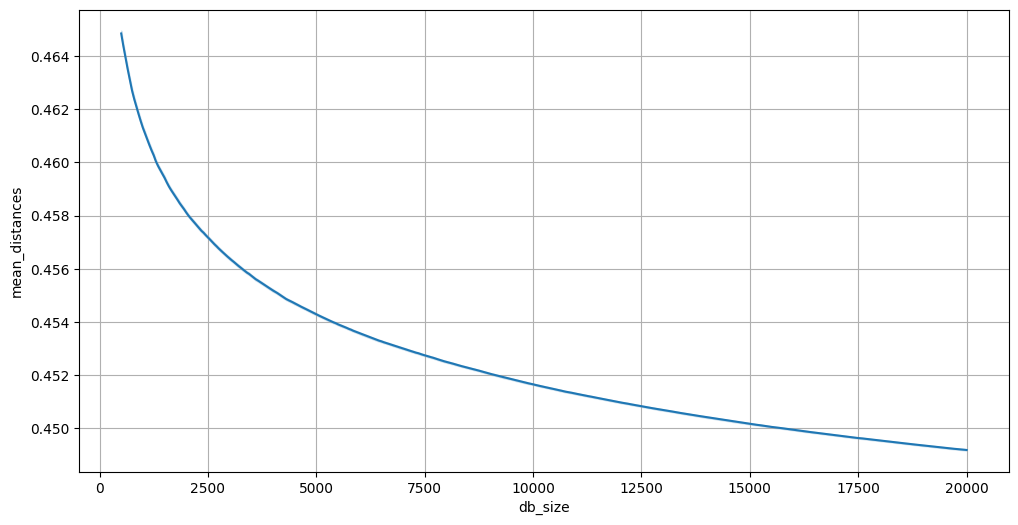

In [461]:
plt.figure(figsize=(12,6))
sns.lineplot(results[results['layer'] == 0], x='db_size', y='mean_distances')
plt.grid()